# Procesamiento de lenguaje natural
## Desafío 3
### Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import os
import random
import io
import pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2024-06-23 16:11:58.362632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 16:11:58.454208: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 16:11:58.914630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-23 16:11:58.914678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

### Datos
Se utiliza como dataset textos del libro *The Happy Prince and Other Tales* disponible en Project Gutenberg: [The Happy Prince and Other Tales](https://www.gutenberg.org/cache/epub/902/pg902.txt)

In [2]:
file_path = os.path.join("docs", "the_happy_prince_and_other_tales")

with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

print(text[:1000])

The Project Gutenberg eBook of The Happy Prince, and Other Tales
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Happy Prince, and Other Tales

Author: Oscar Wilde

Release date: May 1, 1997 [eBook #902]
                Most recently updated: October 25, 2021

Language: English

Credits: David Price and Paul Redmond


*** START OF THE PROJECT GUTENBERG EBOOK THE HAPPY PRINCE, AND OTHER TALES ***

                          [Picture: Book cover]

                       [Picture: The Happy Prince]





                             The Happy Prince
                             And Othe

In [4]:
def remove_previous_text(text, intro_marker):
    """ remove introduction """
    intro_index = text.find(intro_marker)
    if intro_index !=-1:
        return text[intro_index + len(intro_marker):].strip()
    return text

In [5]:
def remove_text_below(text, end_marker):
    """remove text at the end"""
    end_marker_pos = text.find(end_marker)
    if end_marker_pos != -1:
        return text[:end_marker_pos]
    return text

In [14]:
def remove_lineas_picture(texto):
    patron = r'^\[Picture:.*\]$'
    lineas = texto.splitlines()
    lineas_filtradas = [linea for linea in lineas if not re.match(patron, linea.strip())]
    texto_sin_pictures = '\n'.join(lineas_filtradas)    
    return texto_sin_pictures

In [15]:
def remove_empty_lines(text):
    lines = text.split('\n')
    clean_lines = [line for line in lines if line.strip()]
    clean_text = '\n'.join(clean_lines)
    return clean_text

In [16]:
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

intro_marker = "The Remarkable Rocket                     87"
end_marker = "* * * * *"


cleaned_text = remove_previous_text(text, intro_marker)
cleaned_text = remove_text_below(cleaned_text, end_marker)
cleaned_text = remove_lineas_picture(cleaned_text)
cleaned_text = remove_empty_lines(cleaned_text)

output_file_path = os.path.join("docs", "cleaned_text_2.txt") 

with open(output_file_path, "w", encoding="utf-8") as output_file:
    output_file.write(cleaned_text)

print("Cleaned text saved to:", output_file_path)

Cleaned text saved to: docs/cleaned_text_2.txt


In [17]:
df = pd.read_csv(output_file_path, sep='/n', header=None, engine='python')
df.head()

,0
0,The Happy Prince.
1,"HIGH above the city, on a tall column, stood t..."
2,Prince. He was gilded all over with thin leav...
3,"he had two bright sapphires, and a large red r..."
4,sword-hilt.


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [18]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1390


### Elegir el tamaño del contexto

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences


In [20]:
text = list(df.loc[:,0])
text

['The Happy Prince.',
 'HIGH above the city, on a tall column, stood the statue of the Happy',
 'Prince.  He was gilded all over with thin leaves of fine gold, for eyes',
 'he had two bright sapphires, and a large red ruby glowed on his',
 'sword-hilt.',
 'He was very much admired indeed.  “He is as beautiful as a weathercock,”',
 'remarked one of the Town Councillors who wished to gain a reputation for',
 'having artistic tastes; “only not quite so useful,” he added, fearing',
 'lest people should think him unpractical, which he really was not.',
 '“Why can’t you be like the Happy Prince?” asked a sensible mother of her',
 'little boy who was crying for the moon.  “The Happy Prince never dreams',
 'of crying for anything.”',
 '“I am glad there is some one in the world who is quite happy,” muttered a',
 'disappointed man as he gazed at the wonderful statue.',
 '“He looks just like an angel,” said the Charity Children as they came out',
 'of the cathedral in their bright scarlet cloaks 

In [21]:
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [22]:
text[0]

'The Happy Prince.'

In [23]:
segmented_sentences[0]

['the', 'happy', 'prince']

In [24]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 23.,  39.,  30.,  28.,  32.,  41.,   0.,  22.,  26.,  26.,  25.,
         68., 142.,   0., 240., 260., 235., 114.,  37.,   2.]),
 array([ 1.  ,  1.85,  2.7 ,  3.55,  4.4 ,  5.25,  6.1 ,  6.95,  7.8 ,
         8.65,  9.5 , 10.35, 11.2 , 12.05, 12.9 , 13.75, 14.6 , 15.45,
        16.3 , 17.15, 18.  ]),
 <BarContainer object of 20 artists>)

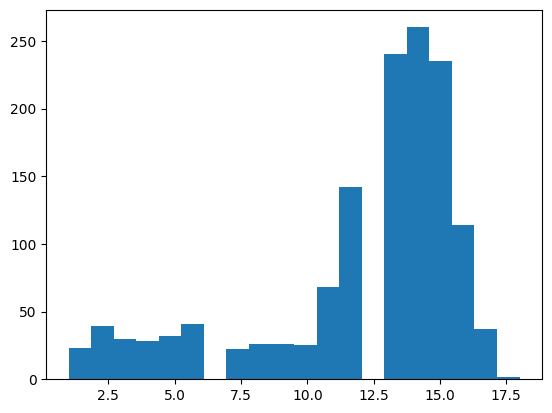

In [25]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [26]:
max_context_size = int(np.percentile(length_sentences, 90)-1)
print(f'max_context_size: {max_context_size}')

max_context_size: 15


###  Tokenizar

In [27]:
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences)
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [28]:
tokenized_sentences[0]

[1, 74, 50]

In [29]:
segmented_sentences[0]

['the', 'happy', 'prince']

### Organizando y estructurando el dataset

In [30]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [31]:
tok_sent = []

for sent in tokenized_sentences_train:
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: 
    tok_sent.append(sent)


In [32]:
len(tok_sent)

1140

In [33]:
tok_sent_augm = []

for sent in tok_sent:

  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [34]:
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [35]:
train_seqs.shape

(12691, 16)

In [36]:
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [37]:
y.shape

(12691, 15)

In [38]:
tok.index_word

{1: 'the',
 2: 'and',
 3: '”',
 4: 'to',
 5: 'a',
 6: 'he',
 7: 'of',
 8: 'i',
 9: 'is',
 10: 'in',
 11: 'was',
 12: 'it',
 13: 'you',
 14: 'that',
 15: 'said',
 16: 'his',
 17: 'for',
 18: 'little',
 19: 'so',
 20: 'as',
 21: 'with',
 22: 'not',
 23: 'my',
 24: '’',
 25: 'at',
 26: 'have',
 27: 'all',
 28: 'but',
 29: 'she',
 30: 'on',
 31: 'am',
 32: 'they',
 33: 'her',
 34: 'had',
 35: 'very',
 36: 'him',
 37: 'are',
 38: 'will',
 39: 'be',
 40: 'me',
 41: '“i',
 42: 'cried',
 43: 'one',
 44: 'were',
 45: 'like',
 46: 'hans',
 47: 'rose',
 48: 'there',
 49: 'out',
 50: 'prince',
 51: 'swallow',
 52: 'no',
 53: 'miller',
 54: 'what',
 55: 'great',
 56: 'when',
 57: 'up',
 58: 'garden',
 59: 'over',
 60: 'who',
 61: 'down',
 62: 'about',
 63: 'into',
 64: 'then',
 65: 'rocket',
 66: 'quite',
 67: 'came',
 68: 'has',
 69: 'answered',
 70: 'red',
 71: 'if',
 72: 'never',
 73: 'away',
 74: 'happy',
 75: 'always',
 76: 'them',
 77: 'would',
 78: 'tree',
 79: 'good',
 80: 'beautiful',
 81:

In [39]:
vocab_size = len(tok.word_counts)
vocab_size

2346

In [40]:
print(tok.word_index)

{'the': 1, 'and': 2, '”': 3, 'to': 4, 'a': 5, 'he': 6, 'of': 7, 'i': 8, 'is': 9, 'in': 10, 'was': 11, 'it': 12, 'you': 13, 'that': 14, 'said': 15, 'his': 16, 'for': 17, 'little': 18, 'so': 19, 'as': 20, 'with': 21, 'not': 22, 'my': 23, '’': 24, 'at': 25, 'have': 26, 'all': 27, 'but': 28, 'she': 29, 'on': 30, 'am': 31, 'they': 32, 'her': 33, 'had': 34, 'very': 35, 'him': 36, 'are': 37, 'will': 38, 'be': 39, 'me': 40, '“i': 41, 'cried': 42, 'one': 43, 'were': 44, 'like': 45, 'hans': 46, 'rose': 47, 'there': 48, 'out': 49, 'prince': 50, 'swallow': 51, 'no': 52, 'miller': 53, 'what': 54, 'great': 55, 'when': 56, 'up': 57, 'garden': 58, 'over': 59, 'who': 60, 'down': 61, 'about': 62, 'into': 63, 'then': 64, 'rocket': 65, 'quite': 66, 'came': 67, 'has': 68, 'answered': 69, 'red': 70, 'if': 71, 'never': 72, 'away': 73, 'happy': 74, 'always': 75, 'them': 76, 'would': 77, 'tree': 78, 'good': 79, 'beautiful': 80, 'by': 81, 'going': 82, 'must': 83, 'really': 84, 'day': 85, 'see': 86, 'your': 87, 

In [41]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'the': 808, 'happy': 31, 'prince': 48, 'above': 3, 'tall': 4, 'a': 326, 'high': 8, 'stood': 5, 'on': 83, 'column': 3, 'city': 9, 'statue': 11, 'of': 283, 'he': 289, 'over': 42, 'gold': 15, 'fine': 8, 'was': 187, 'all': 85, 'with': 108, 'gilded': 1, 'for': 120, 'leaves': 5, 'thin': 2, 'eyes': 19, 'red': 34, 'bright': 6, 'and': 540, 'large': 16, 'two': 14, 'glowed': 2, 'ruby': 9, 'had': 76, 'his': 129, 'sapphires': 2, 'hilt': 2, 'sword': 5, 'weathercock': 1, '”': 381, 'admired': 2, 'beautiful': 30, 'is': 221, '“he': 9, 'much': 23, 'as': 96, 'indeed': 21, 'very': 77, 'to': 320, 'who': 43, 'remarked': 6, 'wished': 1, 'gain': 1, 'reputation': 1, 'councillors': 5, 'one': 61, 'town': 8, 'fearing': 1, 'added': 1, '“only': 3, 'tastes': 2, 'artistic': 1, 'quite': 40, 'useful': 4, 'not': 100, 'so': 115, 'having': 2, 'lest': 1, 'really': 28, 'him': 76, 'should': 19, 'unpractical': 2, 'think': 22, 'people': 15, 'which': 12, 'sensible': 1, 'can’t': 1, 'asked': 11, 'be': 7


### MODELO LSTM

In [44]:
model = Sequential()


model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(Dense(vocab_size+1, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          117350    
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         60400     
                                                                 
 lstm_3 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense_1 (Dense)             (None, None, 2347)        237047    
                                                                 
Total params: 495,197
Trainable params: 495,197
Non-trainable params: 0
_________________________________________________________________


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [45]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name = "my_model", patience=5):
    
      self.val_data = val_data
      self.model_name = model_name

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      
      for seq in self.val_data:

        len_seq = len(seq)
        
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

       
        for start,end in self.info:

        
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

         
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

       
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

       
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [46]:
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name="LSTM_word")], batch_size=16)

Epoch 1/20
792/794 [============================>.] - ETA: 0s - loss: 3.9488
 mean perplexity: 1023.1353840543426 



INFO:tensorflow:Assets written to: LSTM_word/assets


INFO:tensorflow:Assets written to: LSTM_word/assets


Saved new model!
794/794 [==============================] - 16s 17ms/step - loss: 3.9490
Epoch 2/20
791/794 [============================>.] - ETA: 0s - loss: 3.3431
 mean perplexity: 652.8205564097781 



INFO:tensorflow:Assets written to: LSTM_word/assets


INFO:tensorflow:Assets written to: LSTM_word/assets


Saved new model!
794/794 [==============================] - 13s 17ms/step - loss: 3.3423
Epoch 3/20
791/794 [============================>.] - ETA: 0s - loss: 3.1366
 mean perplexity: 645.8633835491042 



INFO:tensorflow:Assets written to: LSTM_word/assets


INFO:tensorflow:Assets written to: LSTM_word/assets


Saved new model!
794/794 [==============================] - 14s 17ms/step - loss: 3.1368
Epoch 4/20
791/794 [============================>.] - ETA: 0s - loss: 3.0139
 mean perplexity: 750.9791862218069 

794/794 [==============================] - 10s 12ms/step - loss: 3.0134
Epoch 5/20
791/794 [============================>.] - ETA: 0s - loss: 2.9294
 mean perplexity: 652.3474117755592 

794/794 [==============================] - 10s 12ms/step - loss: 2.9294
Epoch 6/20
792/794 [============================>.] - ETA: 0s - loss: 2.8643
 mean perplexity: 644.0066350574227 



INFO:tensorflow:Assets written to: LSTM_word/assets


INFO:tensorflow:Assets written to: LSTM_word/assets


Saved new model!
794/794 [==============================] - 13s 17ms/step - loss: 2.8642
Epoch 7/20
791/794 [============================>.] - ETA: 0s - loss: 2.8052
 mean perplexity: 634.3755465925701 



INFO:tensorflow:Assets written to: LSTM_word/assets


INFO:tensorflow:Assets written to: LSTM_word/assets


Saved new model!
794/794 [==============================] - 13s 17ms/step - loss: 2.8044
Epoch 8/20
791/794 [============================>.] - ETA: 0s - loss: 2.7488
 mean perplexity: 814.9302519642582 

794/794 [==============================] - 9s 12ms/step - loss: 2.7487
Epoch 9/20
790/794 [============================>.] - ETA: 0s - loss: 2.6969
 mean perplexity: 674.7057650726334 

794/794 [==============================] - 9s 12ms/step - loss: 2.6963
Epoch 10/20
792/794 [============================>.] - ETA: 0s - loss: 2.6463
 mean perplexity: 571.2160976850754 



INFO:tensorflow:Assets written to: LSTM_word/assets


INFO:tensorflow:Assets written to: LSTM_word/assets


Saved new model!
794/794 [==============================] - 13s 17ms/step - loss: 2.6461
Epoch 11/20
791/794 [============================>.] - ETA: 0s - loss: 2.5973
 mean perplexity: 671.28660007216 

794/794 [==============================] - 10s 12ms/step - loss: 2.5964
Epoch 12/20
794/794 [==============================] - ETA: 0s - loss: 2.5448
 mean perplexity: 603.4645293635597 

794/794 [==============================] - 10s 12ms/step - loss: 2.5448
Epoch 13/20
790/794 [============================>.] - ETA: 0s - loss: 2.4949
 mean perplexity: 589.336969318488 

794/794 [==============================] - 10s 12ms/step - loss: 2.4952
Epoch 14/20
794/794 [==============================] - ETA: 0s - loss: 2.4477
 mean perplexity: 614.2045884244735 

794/794 [==============================] - 10s 12ms/step - loss: 2.4477
Epoch 15/20
794/794 [==============================] - ETA: 0s - loss: 2.4021
 mean perplexity: 599.7999880689644 

Stopping training...
794/794 [================

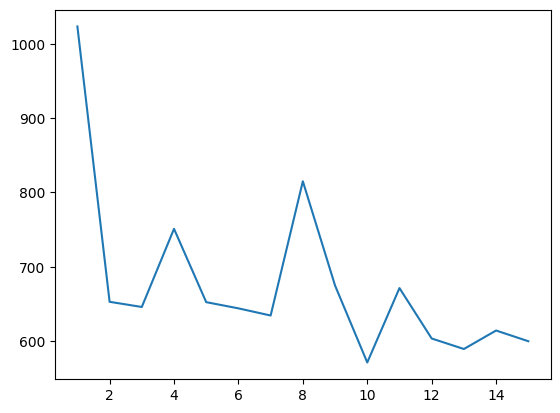

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [48]:

model = keras.models.load_model('LSTM_word')


### Predicción de próxima palabra

In [49]:
import gradio as gr

def model_response(human_text):

    
    encoded = tok.texts_to_sequences([human_text])[0]
   
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

   
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])

    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

   
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 27ms/step
Keyboard interruption in main thread... closing server.


Algunas imagenes obtenidas de gradio:
![img1](images/word1predlstm.png)
![img2](images/word2predlstm.png)
![img3](images/word3predlstm.png)
![img5](images/word5predlstm.png)
![img6](images/word6predlstm.png)
![img7](images/word7predlstm.png)
![img8](images/word8predlstm.png)
![img9](images/word9predlstm.png)



### Generación de secuencias

In [50]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  
    for _ in range(n_words):
      encoded = tokenizer.texts_to_sequences([output_text])[0]
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])
      out_word = ''
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

      output_text += ' ' + out_word

    return output_text

In [51]:
input_text='I am glad there is some'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 13ms/step


'I am glad there is some very rose and the garden and the miller and the'

In [53]:
input_text="He is weeping for"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 13ms/step


'He is weeping for the great rose ” said the miller and the garden'

In [54]:
input_text="And at noon the Student"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 13ms/step


'And at noon the Student was a great rose ” said the miller and the'

In [56]:
input_text="The birds were flying about and twittering"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 12ms/step


'The birds were flying about and twittering he was a great rose ” said the miller and'

In [57]:
input_text="His body was found"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)


1/1 [==============================] - 0s 13ms/step


'His body was found the miller was a great rose ” said the miller'

In [58]:
input_text="Pyrotechnic"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 12ms/step


'Pyrotechnic i am not be a great rose ” said the'

In [59]:
input_text="Fizz"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 13ms/step


'Fizz the garden was a garden and the garden and the'

###  Beam search y muestreo aleatorio

In [60]:
def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [61]:
from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams]
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp))
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)


  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):


    encoded = encode(input)

    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    
    vocab_size = y_hat.shape[0]

    
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

  
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

       
        input_update = np.array([hist[i+1:]]).copy()

        
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [65]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the prince",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the prince as i am be be sound']

In [70]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the prince",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the prince and the red rose ” said']

In [66]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the rocket",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the rocket and the one prince and flew']

In [71]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the rocket",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the rocket and a red rose ” said']

In [67]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the nightingale",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the nightingale and a heart and the heart']

In [72]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the nightingale",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the nightingale was a great rose ” said']

In [68]:
salidas = beam_search(model,num_beams=10,num_words=6,input="red rose",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['red rose ” said the happy thing myself']

In [69]:
salidas = beam_search(model,num_beams=10,num_words=6,input="red rose",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['red rose ” said the miller and the']

### MODELO SIMPLE RNN

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model.add(SimpleRNN(100, return_sequences=True))  # Capa SimpleRNN con 100 unidades y retorno de secuencias
model.add(SimpleRNN(100, return_sequences=True))  # Capa SimpleRNN con 100 unidades y retorno de secuencias
model.add(Dense(vocab_size+1, activation='softmax'))  # Capa de salida con activación softmax

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 50)          117350    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 100)         15100     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, None, 100)         20100     
                                                                 
 dense_8 (Dense)             (None, None, 2347)        237047    
                                                                 
Total params: 389,597
Trainable params: 389,597
Non-trainable params: 0
_________________________________________________________________


In [90]:
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name="SIMPLERNN_word")], batch_size=16)

Epoch 1/20
788/794 [============================>.] - ETA: 0s - loss: 3.8782
 mean perplexity: 1121.3559401077039 



INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


Saved new model!
794/794 [==============================] - 9s 10ms/step - loss: 3.8785
Epoch 2/20
794/794 [==============================] - ETA: 0s - loss: 3.8024
 mean perplexity: 1223.0455067744101 

794/794 [==============================] - 6s 8ms/step - loss: 3.8024
Epoch 3/20
791/794 [============================>.] - ETA: 0s - loss: 3.8020
 mean perplexity: 1106.8039491811166 



INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


Saved new model!
794/794 [==============================] - 8s 10ms/step - loss: 3.8024
Epoch 4/20
790/794 [============================>.] - ETA: 0s - loss: 3.7834
 mean perplexity: 793.4699775302892 



INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


Saved new model!
794/794 [==============================] - 8s 11ms/step - loss: 3.7805
Epoch 5/20
794/794 [==============================] - ETA: 0s - loss: 3.0831
 mean perplexity: 580.6655741257852 



INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


Saved new model!
794/794 [==============================] - 8s 10ms/step - loss: 3.0831
Epoch 6/20
793/794 [============================>.] - ETA: 0s - loss: 2.8501
 mean perplexity: 525.2498027403155 



INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


Saved new model!
794/794 [==============================] - 8s 10ms/step - loss: 2.8502
Epoch 7/20
794/794 [==============================] - ETA: 0s - loss: 2.7116
 mean perplexity: 520.6081196892675 



INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


Saved new model!
794/794 [==============================] - 8s 11ms/step - loss: 2.7116
Epoch 8/20
787/794 [============================>.] - ETA: 0s - loss: 2.5950
 mean perplexity: 522.5242211812441 

794/794 [==============================] - 6s 8ms/step - loss: 2.5928
Epoch 9/20
792/794 [============================>.] - ETA: 0s - loss: 2.4768
 mean perplexity: 515.4019727863006 



INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


INFO:tensorflow:Assets written to: SIMPLERNN_word/assets


Saved new model!
794/794 [==============================] - 8s 9ms/step - loss: 2.4762
Epoch 10/20
788/794 [============================>.] - ETA: 0s - loss: 2.3637
 mean perplexity: 534.9876456464485 

794/794 [==============================] - 6s 8ms/step - loss: 2.3636
Epoch 11/20
793/794 [============================>.] - ETA: 0s - loss: 2.2545
 mean perplexity: 593.5651646700356 

794/794 [==============================] - 6s 8ms/step - loss: 2.2545
Epoch 12/20
788/794 [============================>.] - ETA: 0s - loss: 2.1507
 mean perplexity: 623.5392543406044 

794/794 [==============================] - 6s 8ms/step - loss: 2.1506
Epoch 13/20
787/794 [============================>.] - ETA: 0s - loss: 2.0464
 mean perplexity: 676.5612454169126 

794/794 [==============================] - 6s 8ms/step - loss: 2.0452
Epoch 14/20
794/794 [==============================] - ETA: 0s - loss: 1.9447
 mean perplexity: 780.5225695079419 

Stopping training...
794/794 [=======================

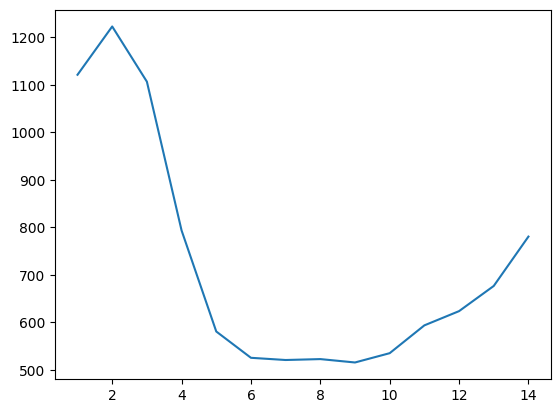

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [93]:
model = keras.models.load_model('SIMPLERNN_word')

### Predicción de próxima palabra

In [94]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 17ms/step
Keyboard interruption in main thread... closing server.


Algunas imagenes obtenidas de gradio:
![img1](images/word1predsimplernn.png)
![img2](images/word2predsimplernn.png)
![img3](images/word3predsimplernn.png)
![img5](images/word4predsimplernn.png)
![img6](images/word5predsimplernn.png)
![img7](images/word6predsimplernn.png)
![img8](images/word7predsimplernn.png)
![img9](images/word8predsimplernn.png)

### Generación de secuencias

In [96]:
input_text='I am glad there is some'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 19ms/step


'I am glad there is some one in the great big plank and his garden and'

In [97]:
input_text="He is weeping for"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 18ms/step


'He is weeping for me to me to his garden and he was a'

In [98]:
input_text="And at noon the Student"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 17ms/step


'And at noon the Student was the very big plank and his garden and the'

In [99]:
input_text="The birds were flying about and twittering"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 18ms/step


'The birds were flying about and twittering the statue of the statue of the statue and the'

In [100]:
input_text="His body was found"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 17ms/step


'His body was found to a very big plank and he was a red'

In [101]:
input_text="Pyrotechnic"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 15ms/step


'Pyrotechnic to be a very big plank and he was a'

In [102]:
input_text="Fizz"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 15ms/step


'Fizz the nightingale came over and the grass and the very'

###  Beam search y muestreo aleatorio

In [103]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the prince",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the prince and the statue of the great']

In [104]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the prince",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the prince ” said the miller and he']

In [105]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the rocket",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the rocket ” said the rocket “i will']

In [106]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the rocket",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the rocket ” said the miller and he']

In [107]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the nightingale",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the nightingale came so to the story of']

In [108]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the nightingale",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the nightingale little swallow ” said the rocket']

In [109]:
salidas = beam_search(model,num_beams=10,num_words=6,input="red rose",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['red rose ” said the swallow “i “impossible']

In [110]:
salidas = beam_search(model,num_beams=10,num_words=6,input="red rose",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['red rose ” said the miller and he']

### MODELO GRU

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Definir el modelo con GRU
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model.add(GRU(100, return_sequences=True))  # Capa GRU con 100 unidades y retorno de secuencias
model.add(GRU(100, return_sequences=True))  # Capa GRU con 100 unidades y retorno de secuencias
model.add(Dense(vocab_size+1, activation='softmax'))  # Capa de salida con activación softmax

# Compilar el modelo
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

# Imprimir el resumen del modelo
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 50)          117350    
                                                                 
 gru_2 (GRU)                 (None, None, 100)         45600     
                                                                 
 gru_3 (GRU)                 (None, None, 100)         60600     
                                                                 
 dense_10 (Dense)            (None, None, 2347)        237047    
                                                                 
Total params: 460,597
Trainable params: 460,597
Non-trainable params: 0
_________________________________________________________________


In [114]:
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name="GRU_word")], batch_size=16)

Epoch 1/20
792/794 [============================>.] - ETA: 0s - loss: 3.5922
 mean perplexity: 788.8729134522009 



INFO:tensorflow:Assets written to: GRU_word/assets


INFO:tensorflow:Assets written to: GRU_word/assets


Saved new model!
794/794 [==============================] - 16s 18ms/step - loss: 3.5919
Epoch 2/20
790/794 [============================>.] - ETA: 0s - loss: 2.9438
 mean perplexity: 533.0348757515437 



INFO:tensorflow:Assets written to: GRU_word/assets


INFO:tensorflow:Assets written to: GRU_word/assets


Saved new model!
794/794 [==============================] - 13s 17ms/step - loss: 2.9441
Epoch 3/20
793/794 [============================>.] - ETA: 0s - loss: 2.7809
 mean perplexity: 499.931463746908 



INFO:tensorflow:Assets written to: GRU_word/assets


INFO:tensorflow:Assets written to: GRU_word/assets


Saved new model!
794/794 [==============================] - 14s 18ms/step - loss: 2.7807
Epoch 4/20
793/794 [============================>.] - ETA: 0s - loss: 2.6693
 mean perplexity: 498.40890699575016 



INFO:tensorflow:Assets written to: GRU_word/assets


INFO:tensorflow:Assets written to: GRU_word/assets


Saved new model!
794/794 [==============================] - 13s 17ms/step - loss: 2.6693
Epoch 5/20
792/794 [============================>.] - ETA: 0s - loss: 2.5792
 mean perplexity: 701.790538883123 

794/794 [==============================] - 10s 13ms/step - loss: 2.5790
Epoch 6/20
791/794 [============================>.] - ETA: 0s - loss: 2.5004
 mean perplexity: 486.2407453263791 



INFO:tensorflow:Assets written to: GRU_word/assets


INFO:tensorflow:Assets written to: GRU_word/assets


Saved new model!
794/794 [==============================] - 15s 18ms/step - loss: 2.5007
Epoch 7/20
793/794 [============================>.] - ETA: 0s - loss: 2.4319
 mean perplexity: 485.7394898383456 



INFO:tensorflow:Assets written to: GRU_word/assets


INFO:tensorflow:Assets written to: GRU_word/assets


Saved new model!
794/794 [==============================] - 14s 18ms/step - loss: 2.4318
Epoch 8/20
792/794 [============================>.] - ETA: 0s - loss: 2.3691
 mean perplexity: 501.08851412504913 

794/794 [==============================] - 10s 13ms/step - loss: 2.3683
Epoch 9/20
792/794 [============================>.] - ETA: 0s - loss: 2.3068
 mean perplexity: 523.9725478089653 

794/794 [==============================] - 10s 13ms/step - loss: 2.3066
Epoch 10/20
793/794 [============================>.] - ETA: 0s - loss: 2.2459
 mean perplexity: 507.14086469375843 

794/794 [==============================] - 10s 13ms/step - loss: 2.2460
Epoch 11/20
794/794 [==============================] - ETA: 0s - loss: 2.1866
 mean perplexity: 530.467317271895 

794/794 [==============================] - 10s 13ms/step - loss: 2.1866
Epoch 12/20
791/794 [============================>.] - ETA: 0s - loss: 2.1300
 mean perplexity: 547.3044674362486 

Stopping training...
794/794 [==============

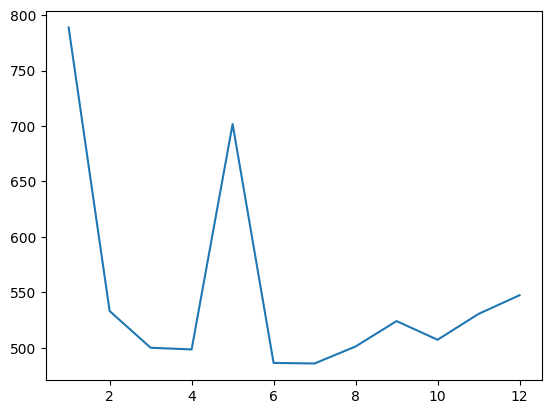

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [116]:
model = keras.models.load_model('GRU_word')

### Predicción de próxima palabra

In [117]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 16ms/step
Keyboard interruption in main thread... closing server.


Algunas imagenes obtenidas de gradio:
![img1](images/word1gru.png)
![img2](images/word2gru.png)
![img3](images/word3gru.png)
![img4](images/word4gru.png)
![img5](images/word5gru.png)
![img6](images/word6gru.png)
![img7](images/word7gru.png)
![img8](images/word8gru.png)

### Generación de secuencias

In [118]:
input_text='I am glad there is some'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 16ms/step


'I am glad there is some wheelbarrow that i am not not not not not not'

In [119]:
input_text="He is weeping for"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 19ms/step


'He is weeping for the garden and a large large large large large large'

In [120]:
input_text="And at noon the Student"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 17ms/step


'And at noon the Student and the great red day and the garden and a'

In [121]:
input_text="The birds were flying about and twittering"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 15ms/step


'The birds were flying about and twittering the garden and a large large large large large large'

In [122]:
input_text="His body was found"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 24ms/step


'His body was found the miller came i am not not not not not'

In [123]:
input_text="Pyrotechnic"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 13ms/step


'Pyrotechnic and the garden and a large large large large large'

In [124]:
input_text="Fizz"
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 13ms/step


'Fizz the next day he was so the great red day'

###  Beam search y muestreo aleatorio

In [125]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the prince",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the prince of the time ” answered the']

In [126]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the prince",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the prince little swallow ” said the swallow']

In [127]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the rocket",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the rocket and the giant was a before']

In [128]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the rocket",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the rocket was a very day ” said']

In [129]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the nightingale",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['the nightingale was very evident i am made']

In [130]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the nightingale",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['the nightingale was very well ” said the']

In [131]:
salidas = beam_search(model,num_beams=10,num_words=6,input="red rose",temp=1,mode='sto')
salidas.shape
decode(salidas[0])

['red rose ” said the swallow “i am']

In [132]:
salidas = beam_search(model,num_beams=10,num_words=6,input="red rose",temp=1,mode='det')
salidas.shape
decode(salidas[0])

['red rose ” said the swallow “i am']